# Operational Space Control

### Start Meshcat Visualizer
Open the visualizer by clicking on the url in the output of this cell.

In [1]:
from pydrake.all import StartMeshcat

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://bf126a1a-17a5-4fc1-b783-5036fc21f155.deepnoteproject.com/7000/


### Setup the simulation

Drake simulations are built as block diagrams, similarly to Simulink or LabVIEW, except the blocks (systems) are defined programatically rather than graphically. 

This cell creates a Drake Diagram, and adds the system blocks for the OSC, footstep planner, and a simulated planar walker. You can change the OSC gains and the desired walking speed, then run this cell to view the diagram it creates. The next cell runs the simulation, which you can view in meshcat.

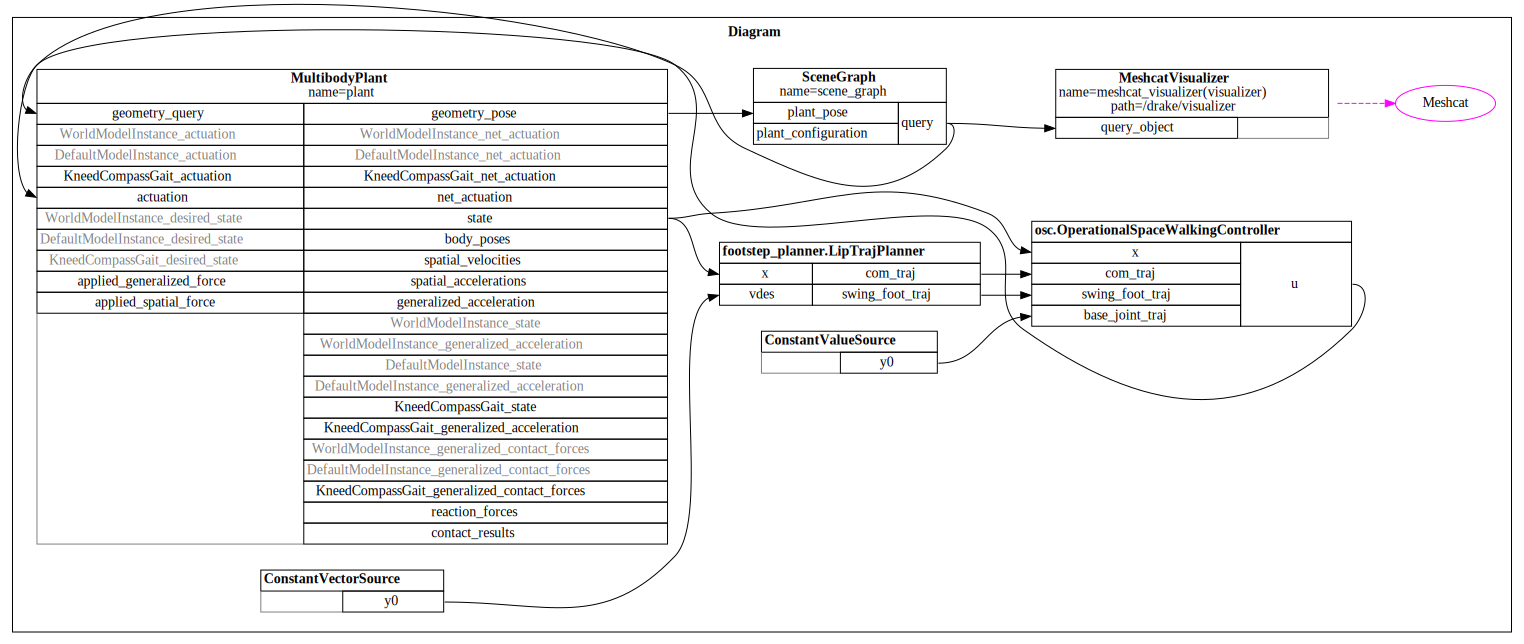

In [4]:
import pydot
import numpy as np
from IPython.display import SVG, display

from pydrake.all import Simulator, DiagramBuilder, AddMultibodyPlantSceneGraph,\
                        Parser, RigidTransform, MeshcatVisualizer, MeshcatVisualizerParams, \
                        ConstantVectorSource, ConstantValueSource, PiecewisePolynomial,\
                        AbstractValue, HalfSpace, CoulombFriction
import footstep_planner
import osc
import importlib
importlib.reload(osc)
importlib.reload(footstep_planner)
from osc import OperationalSpaceWalkingController, OscGains

# Build the block diagram for the simulation
builder = DiagramBuilder()

# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(
    plant.world_body(), 
    X_WG, HalfSpace(), 
    "collision", 
    CoulombFriction(1.0, 1.0)
)
parser = Parser(plant)

# parser.AddModels("humanoid_walker.urdf") # humanoid with 2 arms
parser.AddModels("humanoid_walker2.urdf") # humanoid with 2 arms fixed
# parser.AddModels("planar_walker.urdf") # only lower body

plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()


# Build the controller diagram
Kp = np.diag([100, 0, 100])
Kd = np.diag([10, 0, 10])
W = np.diag([1, 0, 1])

Wcom = np.zeros((3,3))
Wcom[2,2] = 1

# gains for planar walker
# gains = OscGains(
#         Kp, Kd, Wcom,
#         Kp, Kd, W,
#         np.eye(1), np.eye(1), np.eye(1),
#         0.00001
#     )

# gains for humanoid with arms fixed
gains = OscGains(
        Kp, Kd, Wcom,
        Kp, Kd, W,
        60 * np.eye(1), 6 * np.eye(1), np.eye(1),
        0.00001
    )

# TODO: Adjust target walking speed here
# walking_speed = 0.5 # walking speed in m/s for planar walker
walking_speed = 0.2 # walking speed in m/s for humanoid with arms fixed

osc = builder.AddSystem(OperationalSpaceWalkingController(gains))
planner = builder.AddSystem(footstep_planner.LipTrajPlanner())
speed_src = builder.AddSystem(ConstantVectorSource(np.array([walking_speed])))
base_traj_src = builder.AddSystem(
    ConstantValueSource(AbstractValue.Make(PiecewisePolynomial(np.zeros(1,))))
)

# Wire planner inputs 
builder.Connect(plant.get_state_output_port(), 
                planner.get_state_input_port())
builder.Connect(speed_src.get_output_port(), 
                planner.get_walking_speed_input_port())

# Wire OSC inputs
builder.Connect(plant.get_state_output_port(), 
                osc.get_state_input_port()) 
builder.Connect(planner.get_swing_foot_traj_output_port(), 
                osc.get_traj_input_port("swing_foot_traj"))
builder.Connect(planner.get_com_traj_output_port(), 
                osc.get_traj_input_port("com_traj"))
builder.Connect(base_traj_src.get_output_port(), 
                osc.get_traj_input_port("base_joint_traj"))

# Add the visualizer
vis_params = MeshcatVisualizerParams(publish_period=0.01)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)

# Wire OSC to plant
builder.Connect(osc.get_output_port(), 
                plant.get_actuation_input_port())

#simulate
diagram = builder.Build()
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

### Run the simulation
After you have run the above block, you can actually run the simulation with this one.

In [ ]:
# NOTE - if you make changes, you should re-run the cell above this one

sim_time = 10.0
simulator = Simulator(diagram)
simulator.Initialize()
simulator.set_target_realtime_rate(1)

# Set the robot state
plant_context = diagram.GetMutableSubsystemContext(
    plant, simulator.get_mutable_context())
q = np.zeros((plant.num_positions(),))
q[1] = 0.8
theta = -np.arccos(q[1])
q[3] = theta
q[4] = -2 * theta
q[5] = theta
q[6] = -2 * theta
plant.SetPositions(plant_context, q)

import time
time.sleep(3.0)

# Simulate the robot
simulator.AdvanceTo(sim_time)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf126a1a-17a5-4fc1-b783-5036fc21f155' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>